This notebook extracts all the data for our analysis. The base two layers are the plate model (we use the one of Müller et al. (2016), but any plate model could be used) and a set of raster grids of residual abyssal peridotite (RAP) (Merdith et al. 2019). For our anlaysis we limit our time of interest to just the past 5 Ma, but, again, anytime could be used (provided it has a plate model). There are obvious some considerations when applying it further back in time. The general method we have employed to trace the subduction of a slab is after McGirr et al. (2020), however one important difference we make is that we subduct individual 'points', while in McGirr et al. (2022) they connect each point into a subduction isochron.

There are two methods to trace depth, the first one (or default one) is using the approach of McGirr et al. and estimating dip (we use the method of Mather et al. in review, which employs an ensemble machine learning method to predict dip using various parameters such as convergence rate, age of seafloor, slab roll-back etc.). In the second approach we assume dip is 0° (i.e. we explicitly assume that there is no change in depth) and 'subduct' the plate parallel to the Earths surface. We then use the distance-depth from trench data from Slab2 to attach a depth to our 'subducted' points (in this manner we are explicitly mapping points to the surface of Slab2*). With our depth estimates we can then link to the thermal properties of each subduction zone determined by Syracuse et al. (2010) by mapping nearest depth to nearest depth (this is done for both approaches). The output of this notebook contains results for both methods, and the results are broadly similar and become an esimate of uncertainty.

Datasets used are:

-Slab2 (Hayes et al. 2018)

-Syracuse subduction zone thermal data (Syracuse et al. 2010)

-Residual Abyssal Peridotite grids (Merdith et al. 2019; 2020) (+ other various grids such as age, spreading rate etc.))

-Plate model (Müller et al. 2016)

*possibly need to check this, it uses GMT track so it matches that lat-lon of the 0° dip subducted point

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pygplates
from os import walk
import pickle

In [2]:
import pygmt
#import slab_tracker_utils as slab
#import splits_and_merges as snm
import slab_workflow
import gplately

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Helvetica Neue') 
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 8})
#for some reason we get repetitive deprecation warnings, so this mutes them
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning) 


In [3]:
# Call GPlately's DataServer object and download the plate model
rotation_model = pygplates.RotationModel('./data/plate_model/Global_EarthByte_230-0Ma_GK07_AREPS.rot')
topology_features = ['./data/plate_model/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml',
                      './data/plate_model/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml']
static_polygons = pygplates.FeatureCollection('./data/plate_model/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpml')

# Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
#coastlines, continents, COBs = gdownload.get_topology_geometries()




/Users/andrew/Documents/GitHub/gplately/gplately/pygplates.py:192: ImportWarning: 
RotationModel: No filename associated with <class 'pygplates.pygplates.RotationModel'> in __init__
 ensure pygplates is imported from gplately. Run,
 from gplately import pygplates
  _warnings.warn(msg, ImportWarning)


In [4]:
#grids
grid_filename = ['./data/grids/peridotite_thickness_post_serpentinisation_%s_Ma.nc',
                 './data/grids//Muller_etal_2016_AREPS_v1.17_AgeGrid-%s.nc',
                 './data/grids/rategrid_final_mask_%s.nc']


In [5]:
tessellation_threshold_radians = np.deg2rad(0.1)
output_data = slab_workflow.get_subducted_points(5,0,1,model, grid_filename, tessellation_threshold_radians=tessellation_threshold_radians)
        

[(819, 818), (972, 911)]
here (819, 972)
[(564, 674)]
here (564,)
[(904, 802), (969, 901)]
here (904, 969)
[]
[]
[]
5
times 5 -1 -1
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 5.00 to 4.00 Ma stage pole for plate 564
4
times 4 -1 -1
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
3
times 3 -1 -1
2
times 2 -1 -1
1
times 1 -1 -1
0
times 0 -1 -1


In [6]:
#organise our results
output_times = []
output_points = []
output_depths = []
output_widths = []
output_peridotite = []
output_slab_age = []
output_spread_rate = []
output_dips = []
output_conv_rate = []
output_sub_ids = []
output_no_dip_points = []
output_distances = []
for ind, output_at_time in enumerate(output_data[::-1]):
    #output_at_time = np.asarray(output_at_time)
    print(ind)
    #print(i.shape)
    tmp_output_times = np.asarray([output_at_time[0]]*len(output_at_time[1]))
    output_times.append(tmp_output_times)
    output_points.append(output_at_time[1])
    output_depths.append(output_at_time[2])
    output_peridotite.append(output_at_time[3][0])
    output_slab_age.append(output_at_time[3][1])
    output_spread_rate.append(output_at_time[3][2])
    output_dips.append(output_at_time[4])
    output_widths.append(output_at_time[5])
    output_conv_rate.append(output_at_time[8])
    output_sub_ids.append(output_at_time[7])
    output_no_dip_points.append(output_at_time[9])
    output_distances.append(output_at_time[10])
    
output_times = np.asarray(output_times, dtype=object)
output_points = np.asarray(output_points, dtype=object)
output_depths = np.asarray(output_depths, dtype=object)
output_peridotite = np.asarray(output_peridotite, dtype=object)
output_slab_age = np.asarray(output_slab_age, dtype=object)
output_spread_rate = np.asarray(output_spread_rate, dtype=object)
output_dips = np.asarray(output_dips, dtype=object)
output_widths = np.asarray(output_widths, dtype=object)
output_conv_rate = np.asarray(output_conv_rate, dtype=object )
output_sub_ids = np.asarray(output_sub_ids, dtype=object )
output_no_dip_points = np.asarray(output_no_dip_points, dtype=object )
output_distances = np.asarray(output_distances, dtype=object)



0
1
2
3
4
5


In [7]:
#take output data and make it flat-
all_sub_times_flat = []
all_points_flat = []
all_depths_flat = []
all_peridotite_flat = []
all_slab_age_flat = []
all_spread_rate_flat = []
all_dips_flat = []
all_widths_flat = []
all_conv_rate_flat = []
all_sub_ids_flat = []
all_no_dip_points_flat = []
all_distances_flat = []

for ind, output_point in enumerate(output_points):
    for ind2, point in enumerate(output_point):
        all_sub_times_flat.append(output_times[ind][ind2])
        all_points_flat.append((point.to_lat_lon()[1],
                                point.to_lat_lon()[0]))
        
        all_depths_flat.append(output_depths[ind][ind2])        
        all_peridotite_flat.append(output_peridotite[ind][ind2]/1000)#NBNBNB std is in m, mean is in km
        all_slab_age_flat.append(output_slab_age[ind][ind2])
        all_spread_rate_flat.append(output_spread_rate[ind][ind2])
        all_dips_flat.append(output_dips[ind][ind2])
        all_widths_flat.append(output_widths[ind][ind2])
        all_conv_rate_flat.append(float(output_conv_rate[ind][ind2]))
        all_sub_ids_flat.append(float(output_sub_ids[ind][ind2]))
        all_no_dip_points_flat.append((output_no_dip_points[ind][ind2].to_lat_lon()[1],
                                       output_no_dip_points[ind][ind2].to_lat_lon()[0]))
        all_distances_flat.append(float(output_distances[ind][ind2]))
        
all_sub_times_flat = np.asarray(all_sub_times_flat)        
all_points_flat = np.asarray(all_points_flat)        
all_depths_flat = np.asarray(all_depths_flat)        
all_peridotite_flat = np.asarray(all_peridotite_flat)
#when doing STD some are negative
all_peridotite_flat[all_peridotite_flat < 0] = 0.01
all_slab_age_flat = np.asarray(all_slab_age_flat)
all_spread_rate_flat = np.asarray(all_spread_rate_flat)
all_dips_flat = np.asarray(all_dips_flat)        
all_widths_flat = np.asarray(all_widths_flat)        
all_conv_rate_flat = np.asarray(all_conv_rate_flat)
all_sub_ids_flat = np.asarray(all_sub_ids_flat)     
all_no_dip_points_flat = np.asarray(all_no_dip_points_flat)     
all_distances_flat = np.asarray(all_distances_flat)



/Users/andrew/miniforge3/envs/pyTESTSLABS_env/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/andrew/miniforge3/envs/pyTESTSLABS_env/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/andrew/miniforge3/envs/pyTESTSLABS_env/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


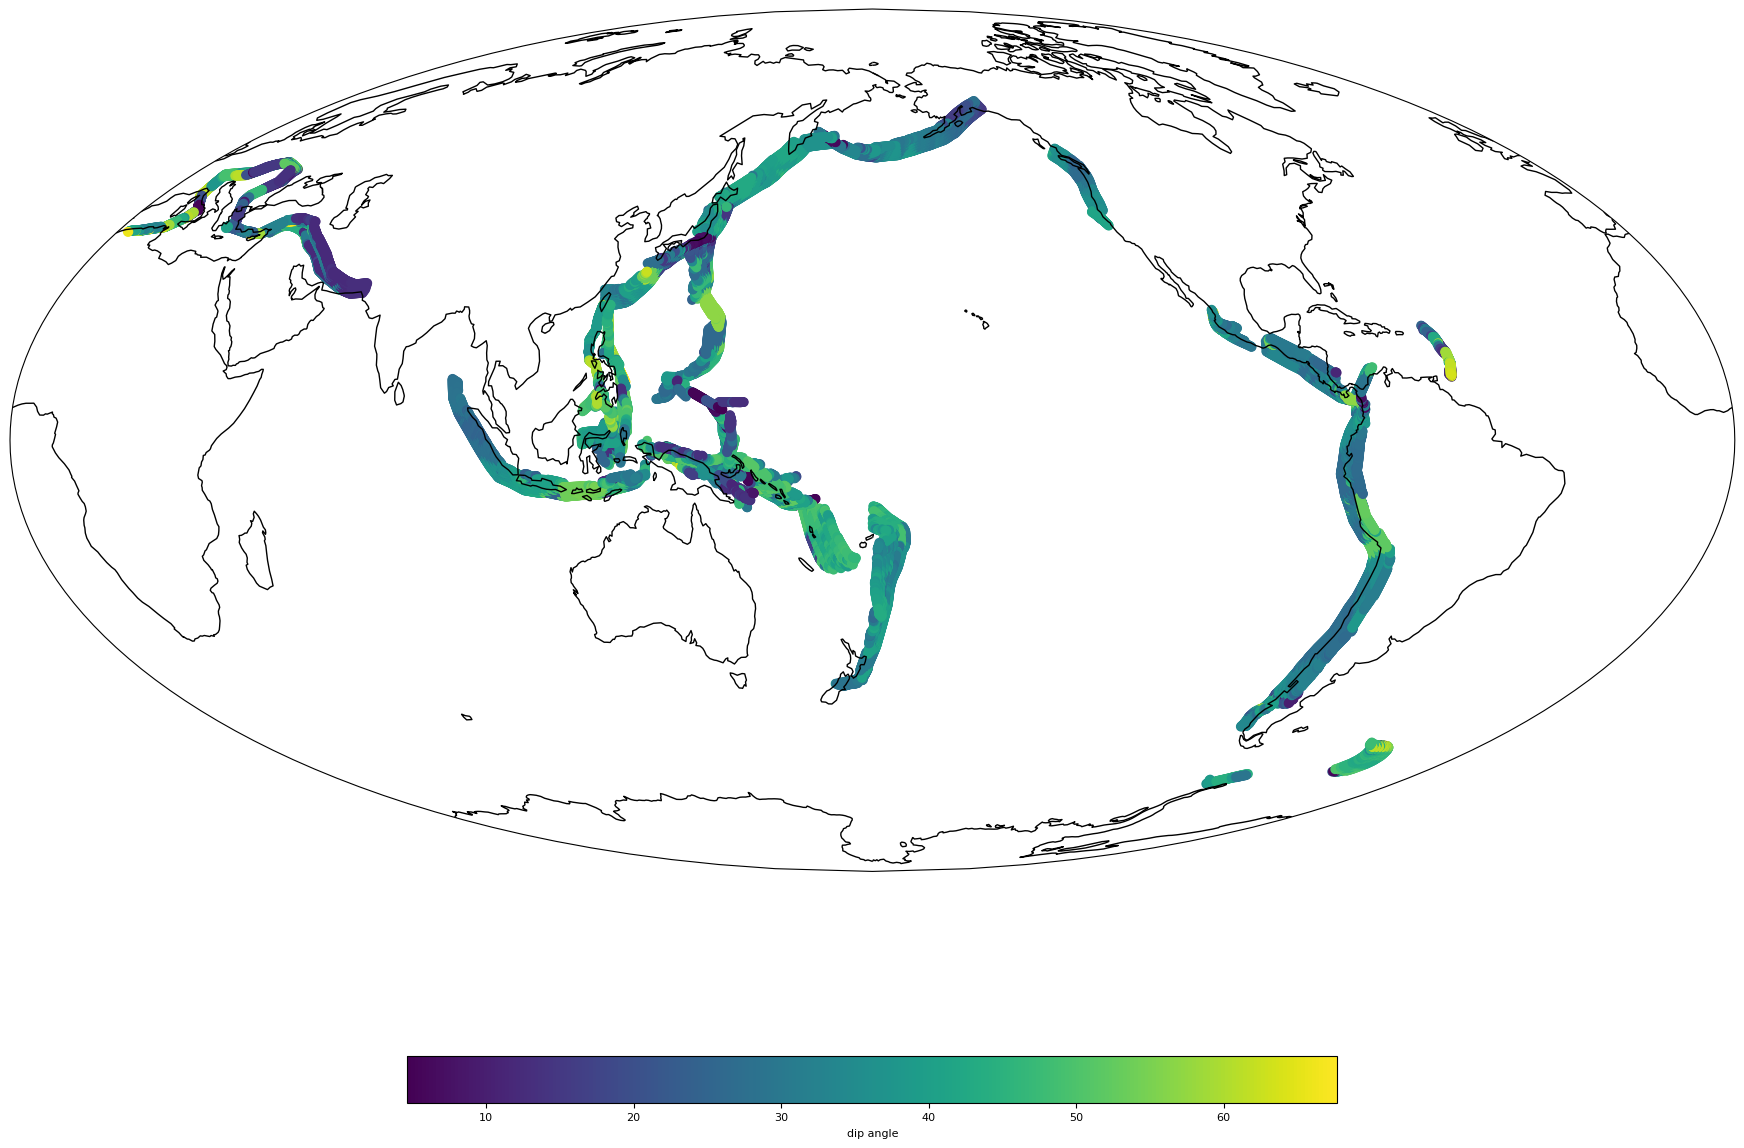

In [9]:
#quick plot to make sure everything is looking okay
proj = ccrs.Mollweide(central_longitude=180)
extent_globe = [-180,180,-90,90]

fig = plt.figure(figsize=(24,16))
ax = plt.axes(projection=proj)
ax.set_global()
sc = ax.scatter(all_points_flat[:,0],
                all_points_flat[:,1], c=all_dips_flat, transform=ccrs.PlateCarree() )

#ax.scatter(track_dep.iloc[:,0].values,
#           track_dep.iloc[:,1].values, c=track_dep.iloc[:,2].values, transform=ccrs.PlateCarree())

#im = ax.imshow(ds_dep['z'], extent=extent_globe, origin='lower', transform=ccrs.PlateCarree(),cmap='inferno')
ax.coastlines()
fig.colorbar(sc, orientation='horizontal', shrink=0.5, label='dip angle')

/Users/andrew/miniforge3/envs/pyTESTSLABS_env/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/andrew/miniforge3/envs/pyTESTSLABS_env/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/andrew/miniforge3/envs/pyTESTSLABS_env/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


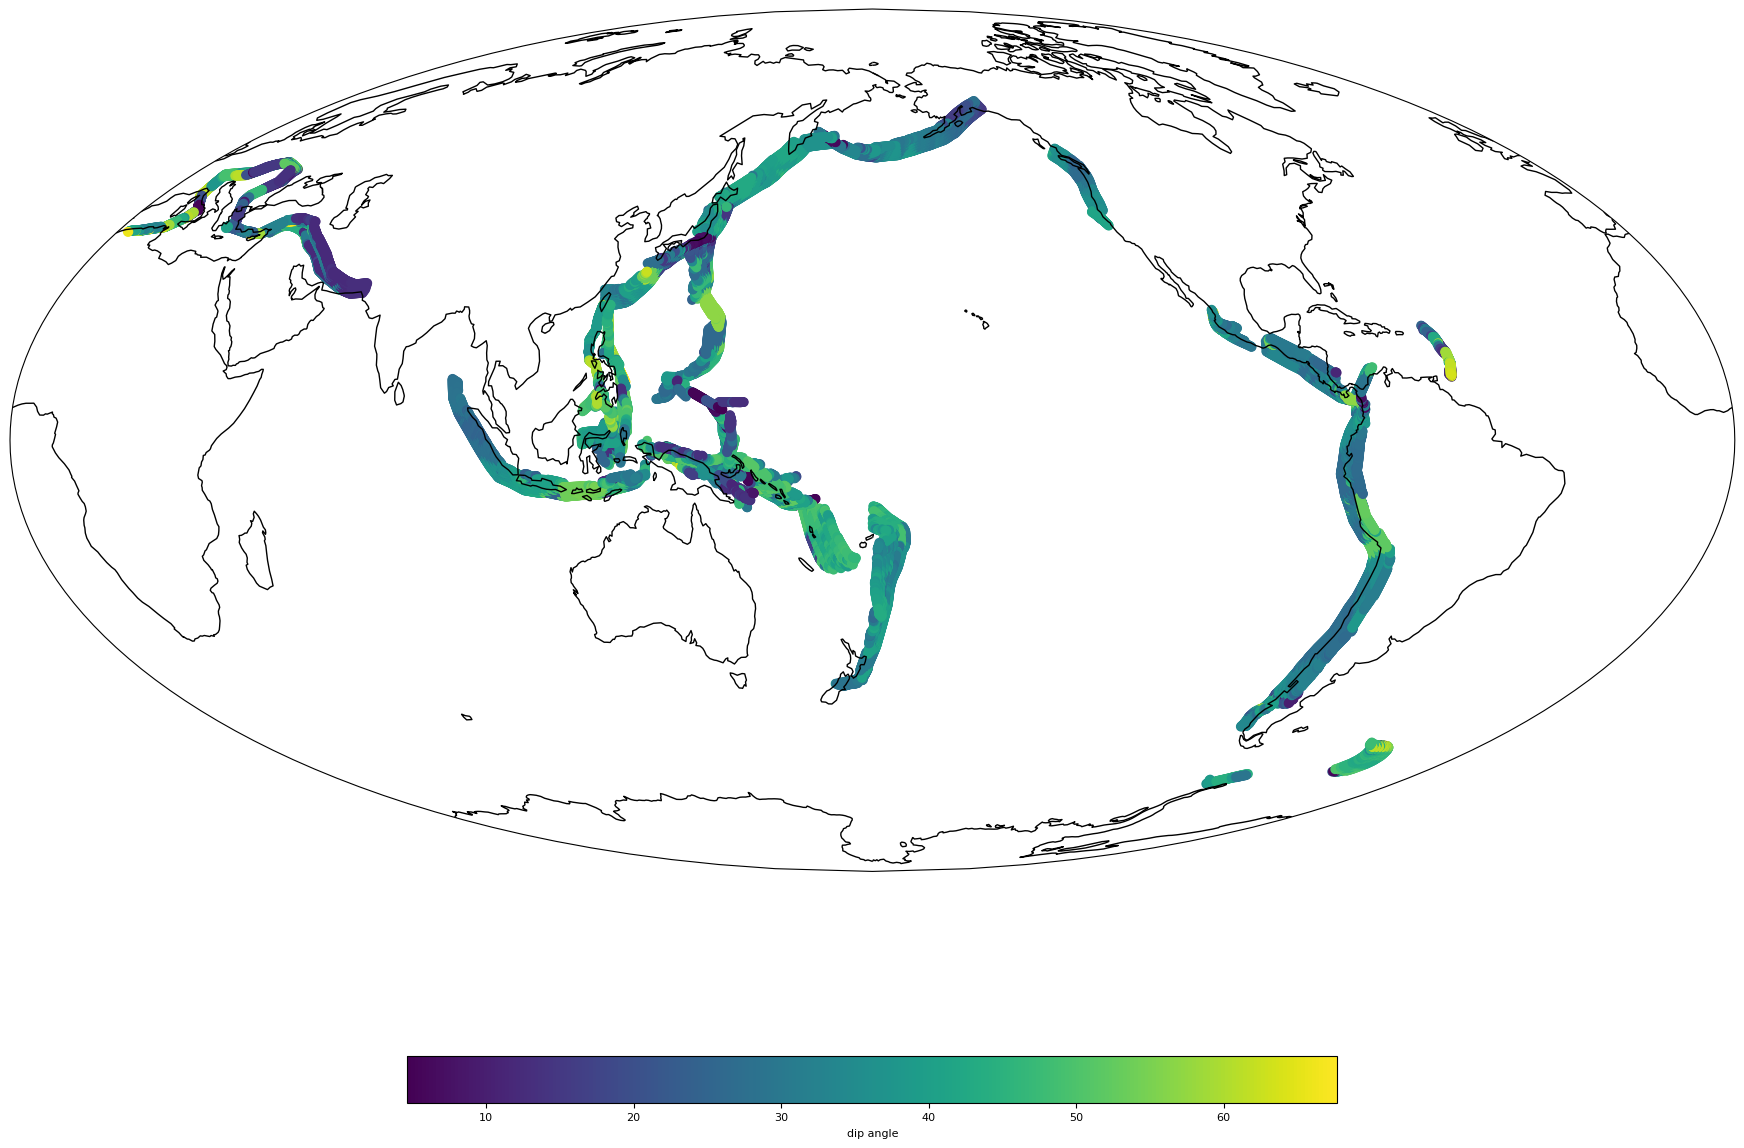

In [10]:
#quick plot to make sure everything is looking okay
proj = ccrs.Mollweide(central_longitude=180)
extent_globe = [-180,180,-90,90]

fig = plt.figure(figsize=(24,16))
ax = plt.axes(projection=proj)
ax.set_global()
sc = ax.scatter(all_points_flat[:,0],
                all_points_flat[:,1], c=all_dips_flat, transform=ccrs.PlateCarree() )

#ax.scatter(track_dep.iloc[:,0].values,
#           track_dep.iloc[:,1].values, c=track_dep.iloc[:,2].values, transform=ccrs.PlateCarree())

#im = ax.imshow(ds_dep['z'], extent=extent_globe, origin='lower', transform=ccrs.PlateCarree(),cmap='inferno')
ax.coastlines()
fig.colorbar(sc, orientation='horizontal', shrink=0.5, label='dip angle')

/Users/andrew/miniforge3/envs/pyTESTSLABS_env/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/andrew/miniforge3/envs/pyTESTSLABS_env/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/andrew/miniforge3/envs/pyTESTSLABS_env/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


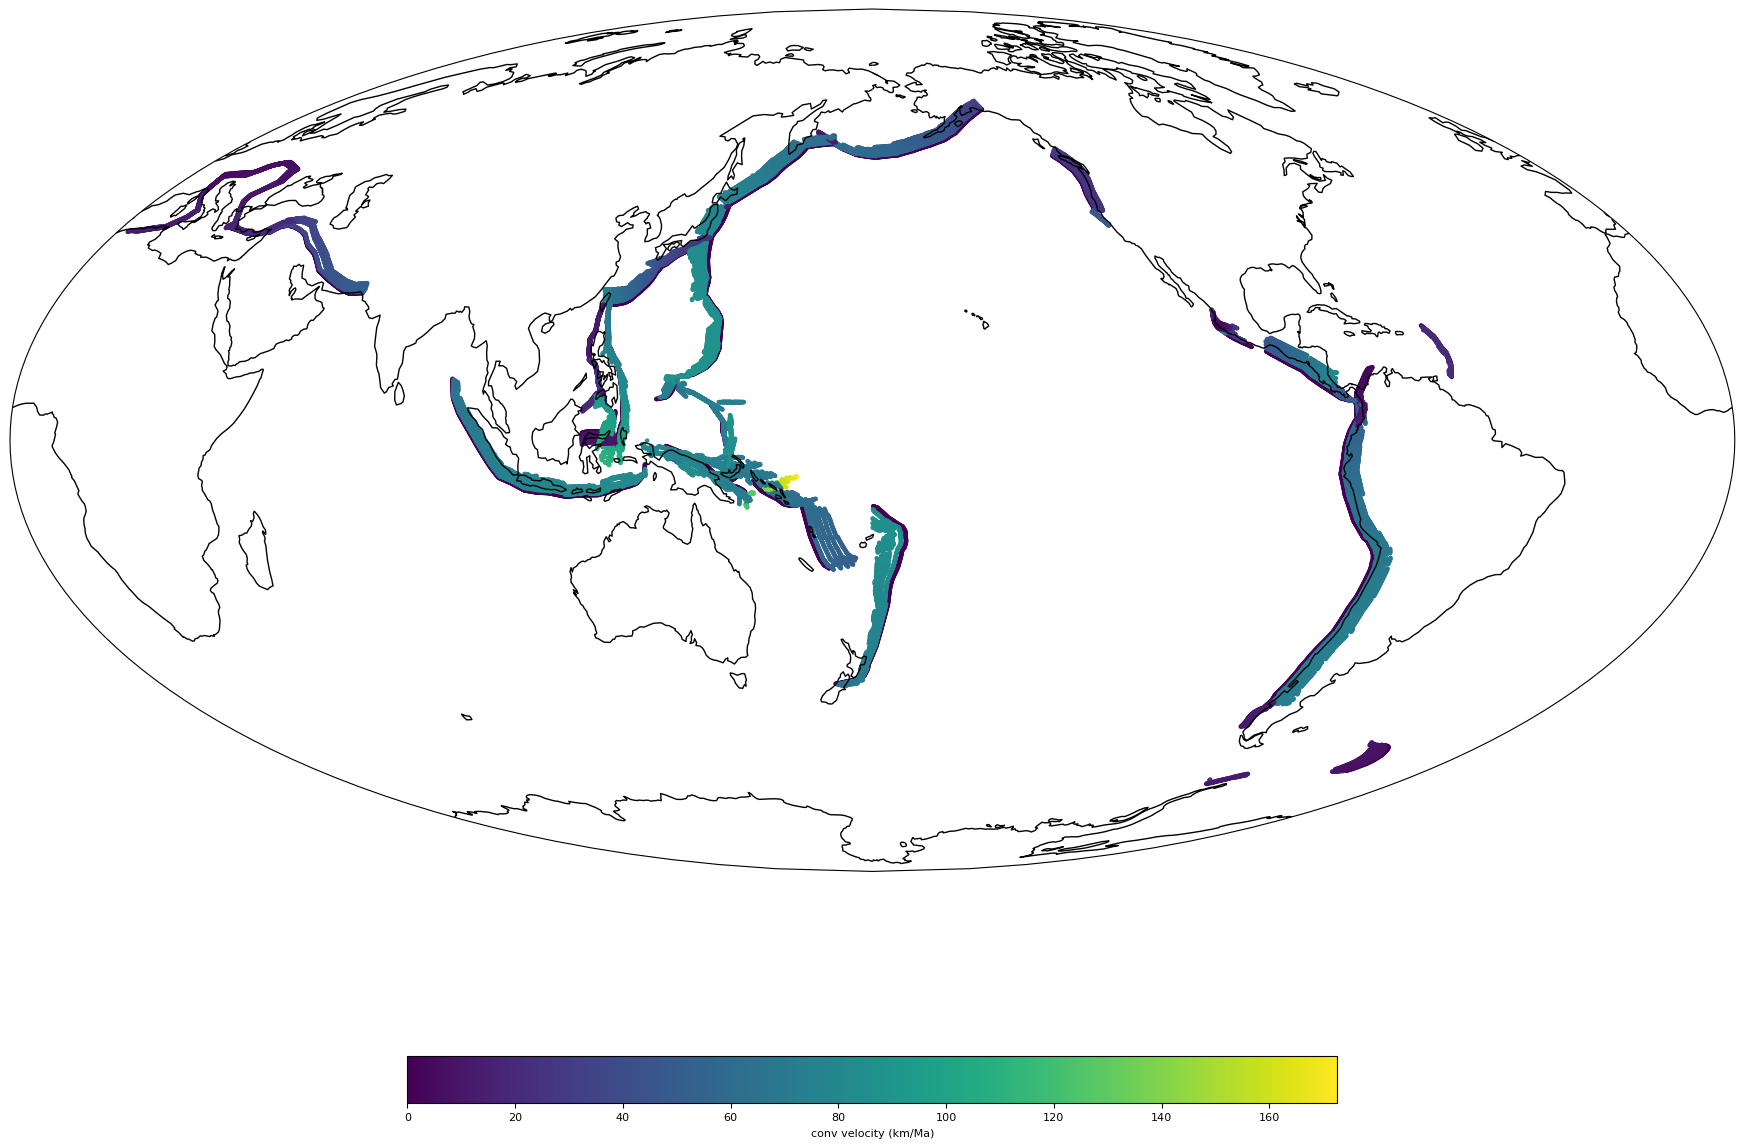

In [11]:
proj = ccrs.Mollweide(central_longitude=180)
extent_globe = [-180,180,-90,90]

fig = plt.figure(figsize=(24,16))
ax = plt.axes(projection=proj)
ax.set_global()
sc = ax.scatter(all_points_flat[:,0],
                all_points_flat[:,1], c=all_conv_rate_flat, s=5, transform=ccrs.PlateCarree() )

#ax.scatter(track_dep.iloc[:,0].values,
#           track_dep.iloc[:,1].values, c=track_dep.iloc[:,2].values, transform=ccrs.PlateCarree())

#im = ax.imshow(ds_dep['z'], extent=extent_globe, origin='lower', transform=ccrs.PlateCarree(),cmap='inferno')
ax.coastlines()
fig.colorbar(sc, orientation='horizontal', shrink=0.5, label='conv velocity (km/Ma)')

/Users/andrew/miniforge3/envs/pyTESTSLABS_env/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/andrew/miniforge3/envs/pyTESTSLABS_env/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/andrew/miniforge3/envs/pyTESTSLABS_env/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


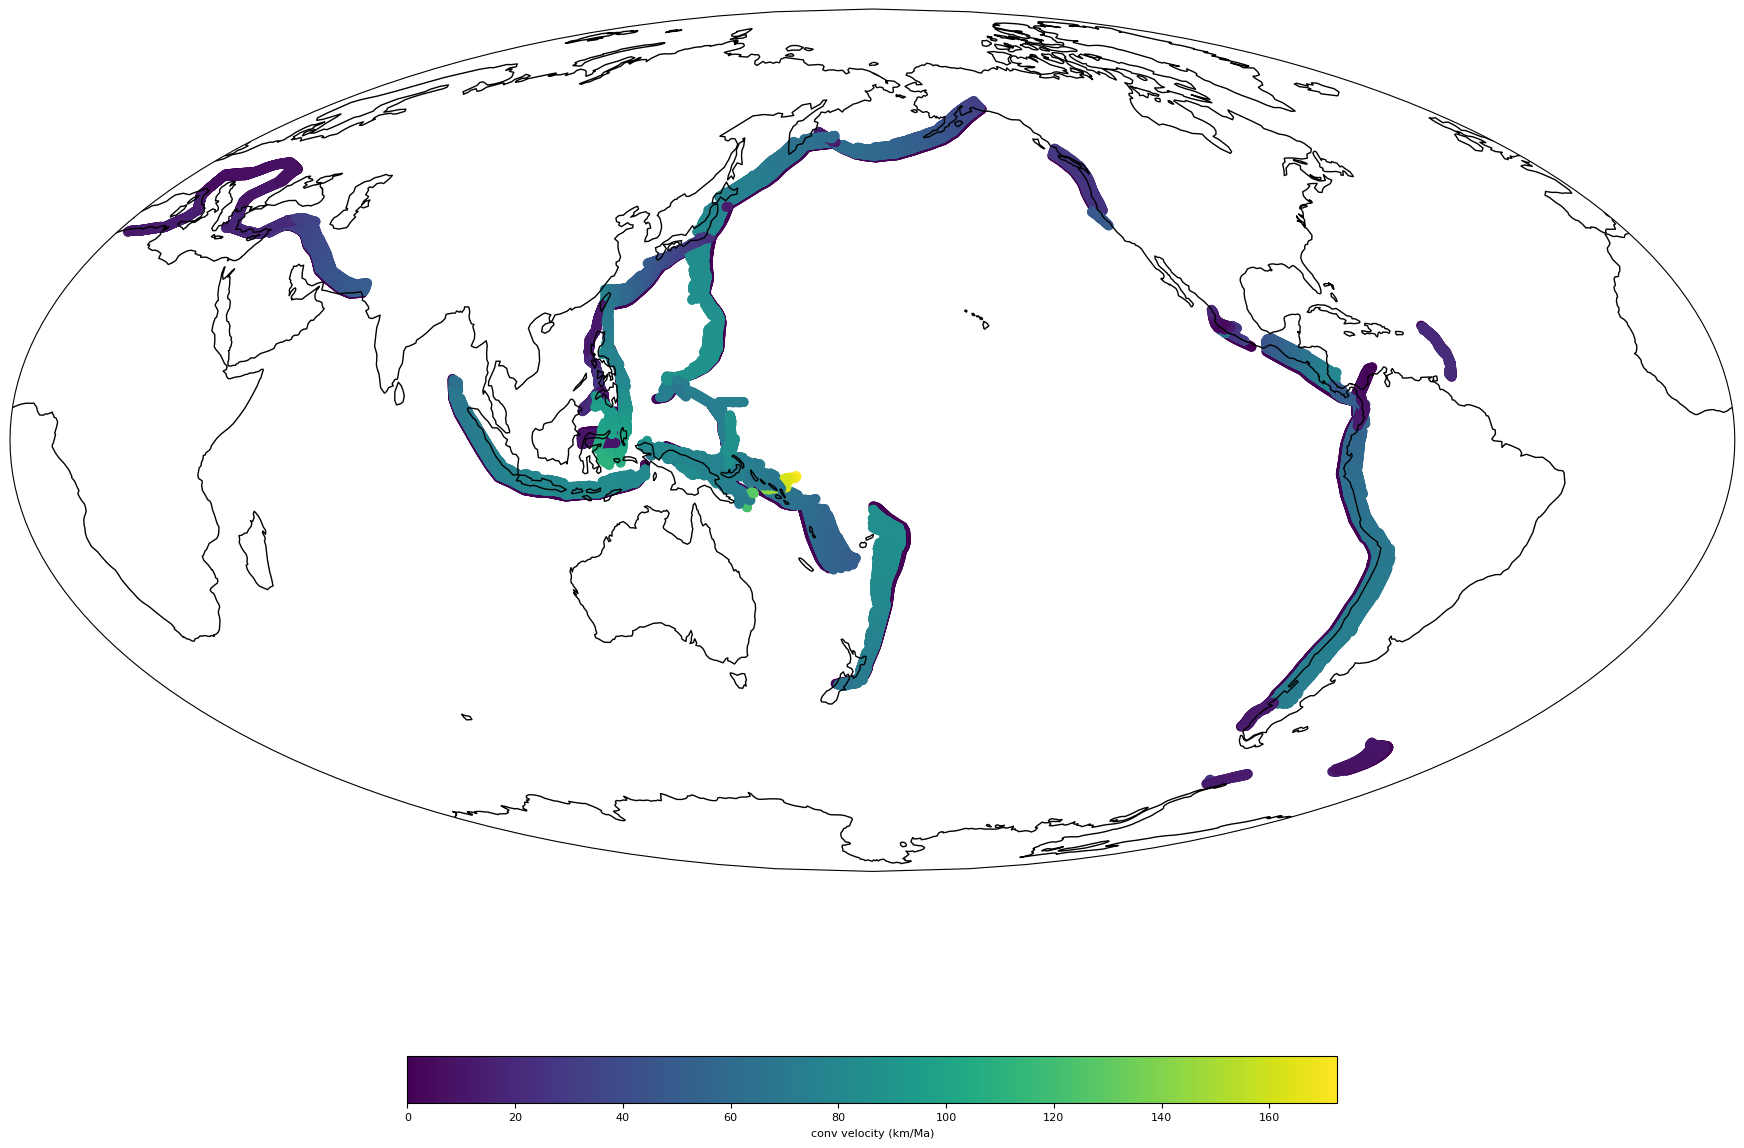

In [12]:
proj = ccrs.Mollweide(central_longitude=180)
extent_globe = [-180,180,-90,90]

fig = plt.figure(figsize=(24,16))
ax = plt.axes(projection=proj)
ax.set_global()
sc = ax.scatter(all_points_flat[:,0],
                all_points_flat[:,1], c=all_conv_rate_flat, transform=ccrs.PlateCarree() )

#ax.scatter(track_dep.iloc[:,0].values,
#           track_dep.iloc[:,1].values, c=track_dep.iloc[:,2].values, transform=ccrs.PlateCarree())

#im = ax.imshow(ds_dep['z'], extent=extent_globe, origin='lower', transform=ccrs.PlateCarree(),cmap='inferno')
ax.coastlines()
fig.colorbar(sc, orientation='horizontal', shrink=0.5, label='conv velocity (km/Ma)')

In [13]:
#get slab2 data
ds_dep = xr.open_dataset('./data/Slab2_compiled_dep.nc')
ds_dip = xr.open_dataset('./data/Slab2_compiled_dip.nc')
ds_unc = xr.open_dataset('./data/Slab2_compiled_unc.nc')

#get points from Slab2 ASSUMING no dip 
track_dep = pygmt.grdtrack(points=all_no_dip_points_flat, grid=ds_dep['z'], newcolname='dep')#, Verbose=False)
track_dip = pygmt.grdtrack(points=all_no_dip_points_flat, grid=ds_dip['z'], newcolname='dip')#, Verbose=False)
track_unc = pygmt.grdtrack(points=all_no_dip_points_flat, grid=ds_unc['z'], newcolname='unc')#, Verbose=False)


#our data so far is in - km, lets convert to (positive) km
track_dep.iloc[:,2] = track_dep.iloc[:,2]*-1
track_unc.iloc[:,2] = track_unc.iloc[:,2]*-1




Integrate P&T data from Syracuse et al.

In [14]:
# Options for Model are:
#  - D80
#  - X25
#  - W1300
#  - T550
MODEL = 'T550'
datadir = '/Users/andrew/Documents/Data/Merdith_sub_zones/'
SlabDir = '%ssyracuse_thermal/Syracuse++_supp_Material/models/%s' % (datadir, MODEL)

files=[]
for(dirpath,dirnames,filenames) in walk(SlabDir):
    files.extend(filenames)
    break
files.sort()
#print f
arcs = []
for file in files:
    arcs.append(file.split('.')[0])
    
#slab surface | moho surface | slab curie depth | magnetite depth | moho curie depth
surface_arrays = []
isotherm_arrays = []
for j in np.arange(len(files)):

        FNAME = files[j]

        tmp_surface_arrays, tmp_isotherm_arrays = slab_workflow.get_slab_surfaces(SlabDir, FNAME)
        surface_arrays.append(tmp_surface_arrays)
        isotherm_arrays.append(tmp_isotherm_arrays)
        
#NB results are:
#surface (0 for top of slab, 7 for moho) | horiontal distance from trench | depth | temperature

In [15]:
#find nearest subduction zone of SYR10 to each point in our analysis
#load csv data of syracuse
closest_indices = []
closest_sub = []
thermal_data = []

df_syracuse = pd.read_csv('%ssyracuse_thermal/Table_2_sub_parameters.csv' % datadir)
input_lat = all_points_flat[0][1]
input_lon = all_points_flat[0][0]
indices = []
for point_index, point in enumerate(all_points_flat[:]):
    #print(point_index)
    input_lon = point[0]
    input_lat = point[1]
    #sort by lat and lon to get a 'top 10'
    df_sort = df_syracuse.iloc[(df_syracuse['Lat']-int(input_lat)).abs().argsort()[:10]]
    df_close = df_sort.iloc[(df_sort['Lon']-int(input_lon)).abs().argsort()[:10]]
    #to find actual closest we will caclulate the distance between the input lat/lon and the 'top 10'
    distance_to_syracuse = []
    for tmp_lat ,tmp_lon in zip(df_close['Lat'], df_close['Lon']):
        distance_to_syracuse.append(pygplates.GeometryOnSphere.distance(pygplates.PointOnSphere(input_lat,
                                                                                                input_lon),
                                                                        pygplates.PointOnSphere(tmp_lat,
                                                                                                tmp_lon)
                                                                        )
                                   )
        
    min_index = distance_to_syracuse.index(min(distance_to_syracuse))# Find the index of the minimum value.
    df_closest = df_close.iloc[[min_index]]
    closest_index = df_closest.index.tolist()
    #
    ###index of closest will correspond to our slab surface database index
    index_of_closest = slab_workflow.find_with_list(arcs, df_closest['Name'].values[0])
    thermal_data_of_closest = surface_arrays[index_of_closest[0]]
    closest_indices.append(closest_index[0])
    closest_sub.append(df_closest['Name'].values[0])
    thermal_data.append(thermal_data_of_closest)
    indices.append(point_index)
    #

In [ ]:
pressure = ((upper_crust_thickness * rho_upper_crust) +
                (lower_crust_thickness * rho_lower_crust) +
                (upper_mantle_thickness * rho_upper_mantle)) * 9.8

In [16]:
local_model_pressure = []
local_slab2_pressure = []
local_model_temp = []
local_slab2_temp = []
for point_index, point in enumerate(all_points_flat[:]):
    #print(point_index)
    model_point_depth = all_depths_flat[point_index]
    slab2_point_depth = track_dep.iloc[point_index,2]
    local_model_pressure.append(slab_workflow.calc_point_pressure(model_point_depth))
    local_slab2_pressure.append(slab_workflow.calc_point_pressure(slab2_point_depth))
    ##now for thermal data, [1] for slab moho, [0] for slab surface
    syracuse_depths = thermal_data[point_index][1][::,2]
    syracuse_temps = thermal_data[point_index][1][::,3]

    ###get nearest indices (of our depth to syrcause depth)
    vec_nearest_SYR = lambda x: slab_workflow._find_nearest_temp(syracuse_depths, x)
    index_of_nearest_model_depth_SYR = np.abs(syracuse_depths-model_point_depth).argmin()
    index_of_nearest_slab2_depth_SYR = np.abs(syracuse_depths-slab2_point_depth).argmin()
    temp_at_model_depth = syracuse_temps[index_of_nearest_model_depth_SYR]
    temp_at_slab2_depth = syracuse_temps[index_of_nearest_slab2_depth_SYR]
    
    local_model_temp.append(temp_at_model_depth)
    local_slab2_temp.append(temp_at_slab2_depth)
    
local_model_pressure = np.asarray(local_model_pressure)
local_slab2_pressure = np.asarray(local_slab2_pressure)
local_model_temp = np.asarray(local_model_temp)
local_slab2_temp = np.asarray(local_slab2_temp)

In [17]:
#get peridotite volume, crustal volume flux and fraction content of crust
volume_perids = all_peridotite_flat*all_widths_flat*1e-3*all_conv_rate_flat
crust_flux = 7*all_widths_flat*1e-3*all_conv_rate_flat #assume 7 km of crust?
fractional_perid = perids_fraction = np.divide(volume_perids, 
                                               crust_flux,
                                               out=np.zeros_like(volume_perids),
                                               where=crust_flux!=0)

In [18]:
data_dict = {'point_sub_times': all_sub_times_flat,
             'point_lats': all_points_flat[:,0],
             'point_lons': all_points_flat[:,1],
             'point_MODEL_depths': all_depths_flat,
             'point_MODEL_no_DIP_lats': all_no_dip_points_flat[:,0],
             'point_MODEL_no_DIP_lons': all_no_dip_points_flat[:,1],
             'point_MODEL_no_DIP_distances': all_distances_flat,
             'point_SLAB2_depths': track_dep.iloc[:,2],
             'point_SLAB2_uncertainty': track_unc.iloc[:,2],
             'point_widths': all_widths_flat*1e-3,#conver from m to km
             'point_conv_rates': all_conv_rate_flat,
             'point_perids': all_peridotite_flat,
             'volume_perids': volume_perids,
             'fractional_perids':fractional_perid,
             'crust_flux': crust_flux,
             'point_slab_ages': all_slab_age_flat,
             'point_spread_rates': all_spread_rate_flat,
             'point_sub_ids': all_sub_ids_flat,
             'point_MODEL_dips': all_dips_flat,
             'point_SLAB2_dips': track_dip.iloc[:,2],
             'sub_zone_SYR10': closest_sub,
             'pressure_MODEL': local_model_pressure,
             'pressure_SLAB2': local_slab2_pressure,
             'temp_SYR10_MODEL': local_model_temp,
             'temp_SYR10_SLAB2': local_slab2_temp
            }

tracks = pd.DataFrame.from_dict(data_dict)

In [19]:
#save as pickle
#with open('./subduction_tracks_2022-11-02_STD.pickle', 'wb') as f:
    #pickle.dump(tracks, f)